# 1D linearized shallow-water equation with wind stress


In [1]:
cd(@__DIR__)
using Pkg; Pkg.activate(".")
#Pkg.resolve(); Pkg.instantiate(); Pkg.precompile()  # Uncomment if needed for reproducibility

using OrdinaryDiffEq, ComponentArrays, Plots, JLD2, Flux, Random, Statistics, ProgressMeter, StatsBase, ParameterSchedulers, BSON, Printf, Optimisers, Optim, Zygote
using ParameterSchedulers: Stateful
using Flux: Adam

  Activating project at `~/Desktop/Deltares/Final Report Code/Model-2`


In [2]:
#const SEED = rand(UInt) 
const SEED = 9789330474890452400 # 18381078987248293814 -> surrogate 2 
Random.seed!(SEED); println("Using seed = $SEED")

# Simulation and surrogate parameters
wind_name = "periodic"                 # piecewise or periodic or multi-frequency
surrogate_init_state = "small_bump"    # flat or bump or small_bump
longer = true                          # true for longer simulation time

surrogate = 6  
predict_increment = true        # false to predict absolute
use_multi_data = true           # several wind amplitudes training 
use_multi_init = true           # several initial conditions training 

# Training wind multiplication factors
#TRAIN_SCALES = [0.8, 0.9, 1.0, 1.1, 1.2]
TRAIN_SCALES = [0.9, 1.0, 1.2]

# Training different initial conditions
INIT_STATES = ["flat", "small_bump", "bump"]

# Validation split percentage
train_ratio = 0.99

# Training params
learning_rate = 1e-5 # 1e-3 # 1e-4 # 5e-4
n_epochs_sur = 6000 # 30000
batch_size = 32 # 64

n_hidden = 128 # 32 # 64 # 20 # 128 # 256
activation = swish # relu # swish # tanh # sigmoid

# Noise to variables
tau_noise_level = 0.00f0 # no noise
state_noise_level = 0.10f0  # 10% noise
target_noise_level = 0.00f0 # no noise

@show wind_name, surrogate_init_state, longer, predict_increment, use_multi_data
nothing

Using seed = 9789330474890452400
(wind_name, surrogate_init_state, longer, predict_increment, use_multi_data) = ("periodic", "small_bump", true, true, true)


#### Setup

In [3]:
const DEBUG = true
const use_gpu = false

# useful 
n_init_conditions = length(INIT_STATES)
ic_to_idx = Dict("flat" => 1, "small_bump" => 2, "bump" => 3)
idx_to_ic = Dict(1 => "flat", 2 => "small_bump", 3 => "bump")
regenerate = false 

function debug(msg, override::Bool=DEBUG)
    if override
        println(msg)
    end
end

to_device(x) = x
if use_gpu
    try
        using CUDA
        println("CUDA is available. Using GPU.")
        CUDA.seed!(SEED)
        to_device(x) = gpu(x)
    catch e
        println("CUDA.jl not found or error loading it. Using CPU. Error: $e")
    end
else
    println("Using CPU.")
end

Using CPU.


In [4]:
include("model_1d_surge_wave.jl")
include("wind_forcing_functions.jl") 
include("normalization-utils.jl")

colors = palette(:bluegreenyellow)[1:6]
cur_colors = theme_palette(:auto)

In [5]:
# utils
function constant_func(t, value=0.0)
    return value
end

function run_model_and_extract(f::Wave1DSurge_cpu, x0, times, station_idxs)
    prob = ODEProblem(f, x0, (times[1], times[end]))
    sol = solve(prob, Rodas5(), saveat = times, isoutofdomain = (u, p, t) -> any([u.h[i] + D[i] < 0 for i in 1:length(u.h)]), reltol = 1e-8, abstol = 1e-10)

    n_time = length(times)
    n_stat = length(station_idxs)
    H = zeros(n_time, n_stat)
    U = zeros(n_time, n_stat)

    for (i, t) in enumerate(times)
        state = sol(t)
        H[i, :] = state.h[station_idxs]
        U[i, :] = state.u[station_idxs]
    end

    return sol, H, U
end

function make_tau(amplitude=1.0, period=8*3600.0)
    return t -> (amplitude * sin(2π * t / period))^2
end

q_left(t) = constant_func(t, 0.0)
q_right(t) = constant_func(t, 0.0)
nothing

#### Numerical Simulation Data

In [6]:
# Import parameters and reproduce input data 
if longer 
    @load "data/$(surrogate_init_state)_$(wind_name)_longer_parameters.jld2" params
else 
    @load "data/$(surrogate_init_state)_$(wind_name)_parameters.jld2" params 
end 

for (k, v) in params
    eval(:($(Symbol(k)) = $v))
end

nothing

In [7]:
# Create wind stress forcings to compare base vs biased
if wind_name == "AR(2)"
    # Autoregressive process of order 2
    tau_nominal = make_tau_ar(amplitude=amplitude, coeffs=coeffs, sigma=sigma, seed=wind_seed)
    tau_true = make_tau_ar(amplitude=(amplitude * bias_factor), coeffs=coeffs, sigma=sigma, seed=wind_seed)

elseif wind_name == "piecewise"
    # Piecewise constant forcing with noise
    tau_nominal = make_tau_piecewise(amplitude=amplitude, avg_duration=avg_duration, noise_level=noise_level, seed=wind_seed) 
    tau_true = make_tau_piecewise(amplitude=(amplitude * bias_factor), avg_duration=avg_duration, noise_level=0.3, seed=wind_seed)

elseif wind_name == "zero"
    # No wind forcing
    tau_nominal = make_tau_zero() 
    tau_true = make_tau_zero() 

elseif wind_name == "constant"
    # Constant wind stress
    tau_nominal = make_tau_constant(amplitude=amplitude)
    tau_true = make_tau_constant(amplitude=(amplitude * bias_factor))

elseif wind_name == "periodic"
    # Single-frequency periodic forcing
    tau_nominal = make_tau_periodic(amplitude, period)
    tau_true = make_tau_periodic((amplitude * bias_factor), period)

elseif wind_name == "multi-frequency" 
    # Multi-frequency forcing with weighted components
    tau_nominal = make_tau_multifreq(amplitude=amplitude, periods=periods, weights=weights, seed=wind_seed)
    tau_true = make_tau_multifreq(amplitude=(amplitude * bias_factor), periods=periods, weights=weights, seed=wind_seed)
else 
    # Default fallback: periodic forcing
    wind_name == "periodic"
    tau_nominal = make_tau_periodic(amplitude, period)
    tau_true = make_tau_periodic((amplitude * bias_factor), period)
end

#make_tau_periodic##0 (generic function with 1 method)

In [8]:
function generate_data_at_scale(scale::Float64, tau_nominal, physical_params, times, station_idxs; force_regenerate=regenerate)
    filename = joinpath("data_multiscale/", "data_scale_$(scale)_$(physical_params[:init_state])_$(wind_name)_longer$(longer).jld2")

    # Check if data already exists
    if !force_regenerate && isfile(filename)
        println("  Loading existing data for scale=$scale from $filename")
        data = load(filename)
        return data["H"], data["U"], data["tau_func"]
    end
    
    println("  Generating NEW data for scale=$scale...")
    
    # Create scaled tau function
    if wind_name == "periodic"
        tau_scaled = make_tau_periodic(amplitude * scale, period)
    elseif wind_name == "piecewise"
        tau_scaled = make_tau_piecewise(amplitude=amplitude * scale, avg_duration=avg_duration, noise_level=noise_level, seed=wind_seed) 
    elseif wind_name == "AR2"
        tau_scaled = make_tau_ar(amplitude=amplitude * scale, coeffs=coeffs, sigma=sigma, seed=wind_seed)
    elseif wind_name == "multi-frequency"
        tau_scaled = make_tau_multifreq(amplitude=amplitude * scale, periods=periods, weights=weights, seed=wind_seed)
    else
        error("Unknown wind_name: $wind_name")
    end

    # Create model with scaled forcing
    f_scaled = Wave1DSurge_cpu(physical_params[:g], physical_params[:D], physical_params[:L], physical_params[:W], physical_params[:dx], physical_params[:nx], 
                          physical_params[:rho], physical_params[:C], tau_scaled, q_left, q_right)
    # Run simulation
    sol_scaled, H_scaled, U_scaled = run_model_and_extract(f_scaled, physical_params[:x0], times, station_idxs)
    
    # Save to disk
    save(filename, Dict("H" => H_scaled, "U" => U_scaled, "scale" => scale, "tau_func" => tau_scaled,
                        "times" => times, "wind_name" => wind_name, "init_state" => surrogate_init_state, "longer" => longer))
    
    println("  ✓ Saved data for scale=$scale")
    
    return H_scaled, U_scaled, tau_scaled
end

generate_data_at_scale (generic function with 1 method)

In [9]:
# generate data with 'wrong' wing
if use_multi_data && use_multi_init
    println("\nUsing MULTI-CONDITION training")
    println(" Initial states: $INIT_STATES")
    println(" Wind scales: $TRAIN_SCALES")
    
    # Dataset
    all_H = []
    all_U = []
    all_scales_arr = []
    all_init_state_arr = []  
    all_tau_funcs = []
    
    # Pre-load and cache parameters for each initial condition
    init_params_cache = Dict()
    for init_st in INIT_STATES
        if longer
            param_file = "data/$(init_st)_$(wind_name)_longer_parameters.jld2"
        else
            param_file = "data/$(init_st)_$(wind_name)_parameters.jld2"
        end
        
        if isfile(param_file)
            @load param_file params
            init_params_cache[init_st] = params
            println("  Loaded parameters for init_state=$init_st")
        else
            error("Parameter file not found: $param_file")
        end
    end
    
    # Generate data for each (surrogate_init_state, scale) combination
    @showprogress for init_st in INIT_STATES
        # Load parameters for this initial condition
        params = init_params_cache[init_st]
        current_physical_params = Dict(
            :D => params[:D], :x0 => params[:x0], :g => params[:g], :L => params[:L], :W => params[:W], :dx => params[:dx], :nx => params[:nx],
            :rho => params[:rho], :C => params[:C], :amplitude => params[:amplitude], :period => params[:period], :init_state => params[:init_state]
        )

        for scale in TRAIN_SCALES
            # Generate scaled data
            H_scale, U_scale, tau_scale = generate_data_at_scale(scale, tau_nominal, current_physical_params, times, station_idxs; force_regenerate=regenerate)

            # Store data and metadata
            push!(all_H, H_scale)
            push!(all_U, U_scale)
            push!(all_scales_arr, fill(scale, size(H_scale, 1)))
            push!(all_init_state_arr, fill(init_st, size(H_scale, 1)))  
            push!(all_tau_funcs, tau_scale)
        end
    end
    
    # Combine all datasets
    H_combined = vcat(all_H...)
    U_combined = vcat(all_U...)
    scales_combined = vcat(all_scales_arr...)
    init_states_combined = vcat(all_init_state_arr...)  
    
    println("\n✓ Combined dataset:")
    println("  Total samples: $(size(H_combined, 1))")
    println("  Initial conditions: $(unique(init_states_combined))")
    println("  Wind scales: $(unique(scales_combined))")
    
    H_nominal = H_combined
    U_nominal = U_combined
    
elseif use_multi_data
    println("\nUsing MULTI-SCALE training (scales: $(TRAIN_SCALES))")

    # Dataset
    all_H = []
    all_U = []
    all_scales_arr = []
    all_tau_funcs = []
    
    current_physical_params = Dict(
        :D => params[:D], :x0 => params[:x0], :g => params[:g], :L => params[:L], :W => params[:W], :dx => params[:dx], :nx => params[:nx],
        :rho => params[:rho], :C => params[:C], :amplitude => params[:amplitude], :period => params[:period], :init_state => params[:init_state]
    )

    # Get the different scaled data
    @showprogress for scale in TRAIN_SCALES
        H_scale, U_scale, tau_scale = generate_data_at_scale(scale, tau_nominal, current_physical_params, times, station_idxs; force_regenerate=regenerate)

        push!(all_H, H_scale)
        push!(all_U, U_scale)
        push!(all_scales_arr, fill(scale, size(H_scale, 1)))
        push!(all_tau_funcs, tau_scale)
    end

    # Combine the datasets
    H_combined = vcat(all_H...)
    U_combined = vcat(all_U...)
    scales_combined = vcat(all_scales_arr...)
    init_states_combined = fill(surrogate_init_state, size(H_nominal, 1))

    println("\nCombined dataset:")
    println("  Total samples: $(size(H_combined, 1))")
    println("  Original samples per scale: $(size(all_H, 1))")
    println("  Scaling factor: $(size(H_combined, 1) / size(all_H, 1))")
    
    # Use combined data for training
    H_nominal = H_combined
    U_nominal = U_combined

elseif use_multi_init
    println("\nUsing MULTI-INIT training (initial states: $INIT_STATES)")
    
    # Dataset
    all_H = []
    all_U = []
    all_scales_arr = []
    all_init_state_arr = []
    all_tau_funcs = []

    # Pre-load parameters for each initial condition
    init_params_cache = Dict()
    for init_st in INIT_STATES
        if longer
            param_file = "data/$(init_st)_$(wind_name)_longer_parameters.jld2"
        else
            param_file = "data/$(init_st)_$(wind_name)_parameters.jld2"
        end
        if isfile(param_file)
            @load param_file params
            init_params_cache[init_st] = params
            println("   Loaded parameters for init_state=$init_st")
        else
            error("Parameter file not found: $param_file")
        end
    end

    # Generate data for each initial condition at scale=1.0
    @showprogress for init_st in INIT_STATES
        # Load parameters for this initial condition
        params = init_params_cache[init_st]
        current_physical_params = Dict(
            :D => params[:D], :x0 => params[:x0], :g => params[:g], :L => params[:L], :W => params[:W], :dx => params[:dx], :nx => params[:nx],
            :rho => params[:rho], :C => params[:C], :amplitude => params[:amplitude], :period => params[:period], :init_state => params[:init_state]
        )
        
        # Generate data at scale=1.0
        H_scale, U_scale, tau_scale = generate_data_at_scale(scale, tau_nominal, current_physical_params, times, station_idxs; force_regenerate=regenerate)

        push!(all_H, H_scale)
        push!(all_U, U_scale)
        push!(all_scales_arr, fill(1.0, size(H_scale, 1)))
        push!(all_init_state_arr, fill(init_st, size(H_scale, 1)))
        push!(all_tau_funcs, tau_scale)
    end

    # Combine all datasets
    H_combined = vcat(all_H...)
    U_combined = vcat(all_U...)
    scales_combined = vcat(all_scales_arr...)
    init_states_combined = vcat(all_init_state_arr...)

    println("\n Combined dataset:")
    println("   Total samples: $(size(H_combined, 1))")
    println("   Initial conditions: $(unique(init_states_combined))")
    println("   Wind scales: $(unique(scales_combined))")

    H_nominal = H_combined
    U_nominal = U_combined

else 
    # Use original single-scale approach
    println("\nUsing SINGLE-SCALE training (scale=1.0 only)")

    if longer 
        @load "data/$(surrogate_init_state)_$(wind_name)_longer_parameters.jld2" params
    else 
        @load "data/$(surrogate_init_state)_$(wind_name)_parameters.jld2" params 
    end 

    for (k, v) in params
        eval(:($(Symbol(k)) = $v))
    end

    f_nominal = Wave1DSurge_cpu(g, D, L, W, dx, nx, rho, C, tau_nominal, q_left, q_right)
    sol_nominal, H_nominal, U_nominal = run_model_and_extract(f_nominal, x0, times, station_idxs)

    scales_combined = fill(1.0, size(H_nominal, 1))
    init_states_combined = fill(surrogate_init_state, size(H_nominal, 1))
end
nothing


Using MULTI-CONDITION training
 Initial states: ["flat", "small_bump", "bump"]
 Wind scales: [0.9, 1.0, 1.2]
  Loaded parameters for init_state=flat
  Loaded parameters for init_state=small_bump
  Loaded parameters for init_state=bump
  Generating NEW data for scale=0.9...


┌ Warning: Attempting to store var"#make_tau_periodic##0#make_tau_periodic##1"{Float64, Float64}.
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 /Users/sara/.julia/packages/JLD2/hbsZG/src/data/writing_datatypes.jl:447


  ✓ Saved data for scale=0.9
  Generating NEW data for scale=1.0...


┌ Warning: Attempting to store var"#make_tau_periodic##0#make_tau_periodic##1"{Float64, Float64}.
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 /Users/sara/.julia/packages/JLD2/hbsZG/src/data/writing_datatypes.jl:447


  ✓ Saved data for scale=1.0
  Generating NEW data for scale=1.2...


┌ Warning: Attempting to store var"#make_tau_periodic##0#make_tau_periodic##1"{Float64, Float64}.
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 /Users/sara/.julia/packages/JLD2/hbsZG/src/data/writing_datatypes.jl:447


  ✓ Saved data for scale=1.2
  Generating NEW data for scale=0.9...


┌ Warning: Attempting to store var"#make_tau_periodic##0#make_tau_periodic##1"{Float64, Float64}.
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 /Users/sara/.julia/packages/JLD2/hbsZG/src/data/writing_datatypes.jl:447


  ✓ Saved data for scale=0.9
  Generating NEW data for scale=1.0...


┌ Warning: Attempting to store var"#make_tau_periodic##0#make_tau_periodic##1"{Float64, Float64}.
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 /Users/sara/.julia/packages/JLD2/hbsZG/src/data/writing_datatypes.jl:447


  ✓ Saved data for scale=1.0
  Generating NEW data for scale=1.2...


┌ Warning: Attempting to store var"#make_tau_periodic##0#make_tau_periodic##1"{Float64, Float64}.
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 /Users/sara/.julia/packages/JLD2/hbsZG/src/data/writing_datatypes.jl:447


  ✓ Saved data for scale=1.2


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:11

  Generating NEW data for scale=0.9...


┌ Warning: Attempting to store var"#make_tau_periodic##0#make_tau_periodic##1"{Float64, Float64}.
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 /Users/sara/.julia/packages/JLD2/hbsZG/src/data/writing_datatypes.jl:447


  ✓ Saved data for scale=0.9
  Generating NEW data for scale=1.0...


┌ Warning: Attempting to store var"#make_tau_periodic##0#make_tau_periodic##1"{Float64, Float64}.
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 /Users/sara/.julia/packages/JLD2/hbsZG/src/data/writing_datatypes.jl:447


  ✓ Saved data for scale=1.0
  Generating NEW data for scale=1.2...


┌ Warning: Attempting to store var"#make_tau_periodic##0#make_tau_periodic##1"{Float64, Float64}.
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 /Users/sara/.julia/packages/JLD2/hbsZG/src/data/writing_datatypes.jl:447
Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


  ✓ Saved data for scale=1.2

✓ Combined dataset:
  Total samples: 6489
  Initial conditions: ["flat", "small_bump", "bump"]
  Wind scales: [0.9, 1.0, 1.2]


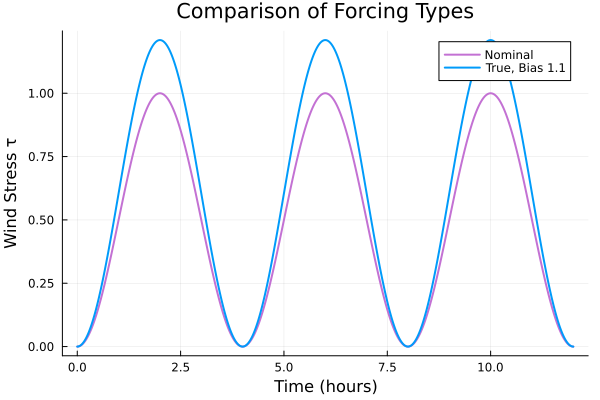


Generating TRUE data (with bias_factor=1.1)...

Generating Nominal data (with bias_factor=1)...


In [10]:
if longer 
    @load "data/$(surrogate_init_state)_$(wind_name)_longer_parameters.jld2" params
else 
    @load "data/$(surrogate_init_state)_$(wind_name)_parameters.jld2" params 
end 

for (k, v) in params
    eval(:($(Symbol(k)) = $v))
end

# both wind functions compared
p = compare_forcings(Dict("Nominal" => tau_nominal,"True, Bias 1.1" => tau_true), times)
display(p)

# Generate 'true' data (observations from the true model)
println("\nGenerating TRUE data (with bias_factor=$bias_factor)...")
f_true = Wave1DSurge_cpu(g, D, L, W, dx, nx, rho, C, tau_true, q_left, q_right)
sol_true, H_true, U_true = run_model_and_extract(f_true, x0, times, station_idxs)

# Generate surrogate training data 
println("\nGenerating Nominal data (with bias_factor=1)...")
f_nominal = Wave1DSurge_cpu(g, D, L, W, dx, nx, rho, C, tau_nominal, q_left, q_right)
sol_nominal_full, H_nominal_full, U_nominal_full = run_model_and_extract(f_nominal, x0, times, station_idxs)

nothing

#### Build supervised learning training pairs


In [11]:
# Input [h_k (station), tau_k (1)] -> target h_{k+1} (station)
n_time = size(H_nominal, 1)
window_size = 1
n_samples = n_time - window_size

# Positions at stations 
D_stations = D[station_idxs]     

# Boundaries mask
mask = ones(Float32, n_stations)
mask[1] = 0.0f0    # Left boundary
mask[end] = 0.0f0    # Right boundary

# Model input
const N_LOCAL_FEATURES = 6   # h, u, D, mask, tau replicated, bias factor (A)
n_in = use_multi_init ? N_LOCAL_FEATURES * n_stations + n_init_conditions : N_LOCAL_FEATURES * n_stations 
n_out = 2 * n_stations  # Δh, Δu (or h_next, u_next)

# Prepare input and target arrays
X_inputs_clean = zeros(Float32, n_samples, n_in) # no noise
X_inputs = zeros(Float32, n_samples, n_in)
Y_targets = zeros(Float32, n_samples, n_out)

# Time vector for all data 
if use_multi_data && use_multi_init
    times_combined = vcat([times for _ in 1:length(TRAIN_SCALES) * length(INIT_STATES)]...)
elseif use_multi_data
    times_combined = vcat([times for _ in 1:length(TRAIN_SCALES)]...)
elseif use_multi_init
    times_combined = vcat([times for _ in 1:length(INIT_STATES)]...)
else
    times_combined = times
end

@show n_time, n_samples, n_stations, N_LOCAL_FEATURES, n_init_conditions, n_in, n_out
println("Input structure: $N_LOCAL_FEATURES features per station × $n_stations stations + $n_init_conditions IC encoding")

nothing

(n_time, n_samples, n_stations, N_LOCAL_FEATURES, n_init_conditions, n_in, n_out) = (6489, 6488, 100, 6, 3, 603, 200)
Input structure: 6 features per station × 100 stations + 3 IC encoding


In [12]:
# Construct input and target arrays for surrogate training
for k in 1:n_samples
    # Get state at time k
    h_k = H_nominal[k, :]  # h 
    u_k = U_nominal[k, :]  # u 

    # Get the scale for this sample
    scale_k = scales_combined[k]
    init_state_k = init_states_combined[k]
    time_k = times_combined[k] 
    
    # Get tau at this time with correct scale
    if use_multi_data
        scale_idx = findfirst(s -> isapprox(s, scale_k), TRAIN_SCALES)
        tau_func_k = all_tau_funcs[scale_idx]
        tau_k = Float32(tau_func_k(time_k))
    else
        # For multi-init only or single case, use nominal tau
        tau_k = Float32(tau_nominal(time_k))
    end

    @assert length(h_k) == n_stations "h_k dimension mismatch: $(length(h_k)) vs n_stations=$n_stations"
    @assert length(u_k) == n_stations "u_k dimension mismatch: $(length(u_k)) vs n_stations=$n_stations"
    
    # Gaussian noise to state 
    h_k_noisy = h_k .+ state_noise_level .* randn(Float32, n_stations)
    u_k_noisy = u_k .+ state_noise_level .* randn(Float32, n_stations)

    # Local features per station 
    for i in 1:n_stations
        idx_base = (i - 1) * N_LOCAL_FEATURES 
        
        # Training inputs (noisy)
        X_inputs[k, idx_base + 1] = h_k_noisy[i]    # h
        X_inputs[k, idx_base + 2] = u_k_noisy[i]    # u
        X_inputs[k, idx_base + 3] = D_stations[i]   # D
        X_inputs[k, idx_base + 4] = mask[i]         # mask
        X_inputs[k, idx_base + 5] = tau_k           # wind stress  
        X_inputs[k, idx_base + 6] = scale_k         # amplitude scale

        # Validation inputs (clean, no noise)
        X_inputs_clean[k, idx_base + 1] = h_k[i]
        X_inputs_clean[k, idx_base + 2] = u_k[i]
        X_inputs_clean[k, idx_base + 3] = D_stations[i]
        X_inputs_clean[k, idx_base + 4] = mask[i]
        X_inputs_clean[k, idx_base + 5] = tau_k
        X_inputs_clean[k, idx_base + 6] = scale_k 
    end
    
    # One-hot encode initial condition at the end of input vector
    if use_multi_init
        X_inputs[k, (N_LOCAL_FEATURES * n_stations + 1) + ic_to_idx[init_state_k] - 1] = 1.0f0
        X_inputs_clean[k, (N_LOCAL_FEATURES * n_stations + 1) + ic_to_idx[init_state_k] - 1] = 1.0f0
    end 

    # Target, future state after window_size steps
    h_next = H_nominal[k + window_size, :]
    u_next = U_nominal[k + window_size, :]
    
    # Predict increments or absolute values
    if predict_increment
        Y_targets[k, 1:n_stations] = (h_next .- h_k) .* (1 .+ target_noise_level .* randn(Float32, n_stations))
        Y_targets[k, (n_stations + 1):end] = (u_next .- u_k) .* (1 .+ target_noise_level .* randn(Float32, n_stations))
    else
        Y_targets[k, 1:n_stations] = h_next .* (1 .+ target_noise_level .* randn(Float32, n_stations))
        Y_targets[k, (n_stations + 1):end] = u_next .* (1 .+ target_noise_level .* randn(Float32, n_stations))
    end
end

# Verify multi-init encodings
if use_multi_init
    println("\n✓ Training data constructed with $(n_init_conditions) initial condition encodings")
    println("  Sample check - IC columns in first sample:")
    for i in 1:n_init_conditions
        col_idx = N_LOCAL_FEATURES * n_stations + i
        println("    $idx_to_ic[i]: $(X_inputs[1, col_idx])")
    end
end 

nothing


✓ Training data constructed with 3 initial condition encodings
  Sample check - IC columns in first sample:
    Dict(2 => "small_bump", 3 => "bump", 1 => "flat")[i]: 1.0
    Dict(2 => "small_bump", 3 => "bump", 1 => "flat")[i]: 0.0
    Dict(2 => "small_bump", 3 => "bump", 1 => "flat")[i]: 0.0


In [13]:
# Split data
n_train = floor(Int, n_samples * train_ratio)

# Index ranges for training and validation
train_idx = 1:n_train
val_idx = (n_train + 1):n_samples

X_train = X_inputs[train_idx, :]   # Noisy
Y_train = Y_targets[train_idx, :]  
X_val = X_inputs_clean[val_idx, :] # Clean
Y_val = Y_targets[val_idx, :]

@show size(X_train), size(Y_train), size(X_val), size(Y_val)
@show n_train, n_time, n_samples

nothing

(size(X_train), size(Y_train), size(X_val), size(Y_val)) = ((6423, 603), (6423, 200), (65, 603), (65, 200))
(n_train, n_time, n_samples) = (6423, 6489, 6488)


In [14]:
function normalize_data(X_train, X_val, Y_train, Y_val, norm_cols_X, mask_cols_X, norm_cols_Y, tau_col_idx;
                       normalize_input=true, normalize_output=true, use_forcing_check=true, eps=1e-8)
    # Normalize both input and output data for network training
    X_train_n, X_val_n, mu_X, sigma_X = nothing, nothing, nothing, nothing
    Y_train_n, Y_val_n, mu_Y, sigma_Y = nothing, nothing, nothing, nothing

    if normalize_input # Input normalization
        if use_forcing_check
            X_train_n, X_val_n, mu_X, sigma_X = normalize_with_forcing_check(X_train, X_val, norm_cols_X, mask_cols_X, tau_col_idx)
        else
            X_train_n, X_val_n, mu_X, sigma_X = robust_normalization(X_train, X_val, setdiff(norm_cols_X, mask_cols_X), mask_cols_X)
        end
        
        # Verify mask integrity
        mask_check_passed = true
        for col in mask_cols_X
            if !all(X_train_n[:, col] .== X_train[:, col])
                println("Column $col was altered during normalization!")
                println("Original values: ", unique(X_train[:, col]))
                println("Normalized values: ", unique(X_train_n[:, col]))
                mask_check_passed = false
            end
        end
        
        if !mask_check_passed
            error("Mask or amplitude scaling columns were normalized! Check mask_cols_X definition.")
        end
    end

    if normalize_output # Output normalization
        Y_train_n = copy(Y_train)
        Y_val_n = copy(Y_val)

        mu_Y = mean(Y_train[:, norm_cols_Y], dims=1)
        sigma_Y = std(Y_train[:, norm_cols_Y], dims=1) .+ eps

        Y_train_n[:, norm_cols_Y] = (Y_train[:, norm_cols_Y] .- mu_Y) ./ sigma_Y
        Y_val_n[:, norm_cols_Y] = (Y_val[:, norm_cols_Y] .- mu_Y) ./ sigma_Y
    end

    # Return normalized datasets and statistics
    return X_train_n, X_val_n, Y_train_n, Y_val_n, mu_X, sigma_X, mu_Y, sigma_Y
end

normalize_data (generic function with 1 method)

In [15]:
# Local features per station
local_cols = vcat([[(i - 1) * N_LOCAL_FEATURES + j for j in 1:N_LOCAL_FEATURES] for i in 1:n_stations]...)
ic_cols = (N_LOCAL_FEATURES * n_stations + 1):(N_LOCAL_FEATURES * n_stations + n_init_conditions)

# Mask columns not normalized
mask_cols_X = []
for i in 1:n_stations
    push!(mask_cols_X, (i - 1) * N_LOCAL_FEATURES + 4) # Mask (4th feature)
    push!(mask_cols_X, (i - 1) * N_LOCAL_FEATURES + 6) # Amplitude scaling factor (6th feature)
end
append!(mask_cols_X, ic_cols) # IC one-hot not-normalized

# All columns to normalize
norm_cols_X = setdiff(vcat(local_cols), mask_cols_X) # exclude mask and A
tau_col_idx = 5                          # tau
norm_cols_Y = 1:(2 * n_stations)         # h and u

# Normalize with util function
X_train_n, X_val_n, Y_train_n, Y_val_n, mu_X, sigma_X, mu_Y, sigma_Y = normalize_data(X_train, X_val, Y_train, Y_val, norm_cols_X, mask_cols_X, norm_cols_Y, tau_col_idx;
                                                                                      normalize_input=true, normalize_output=true, use_forcing_check=true, eps=1e-8)

# Move to device 
X_train_n = to_device(Float32.(X_train_n))
Y_train_n = to_device(Float32.(Y_train_n))
X_val_n = to_device(Float32.(X_val_n))
Y_val_n = to_device(Float32.(Y_val_n))
nothing

┌ Info: Wind forcing is varying (mean=0.5433689, σ=0.4165555).
│ Using standard normalization for all features.
└ @ Main /Users/sara/Desktop/Deltares/Final Report Code/Model-2/normalization-utils.jl:63


In [16]:
@show size(X_inputs), size(Y_targets)
@show size(X_train_n), size(Y_train_n)

# Construct Flux DataLoaders
train_loader = Flux.DataLoader((X_train_n', Y_train_n'), batchsize=min(batch_size, n_train), shuffle=false)
val_loader = Flux.DataLoader((X_val_n', Y_val_n'), batchsize=min(batch_size, size(X_val_n, 1)), shuffle=false)

nothing

(size(X_inputs), size(Y_targets)) = ((6488, 603), (6488, 200))
(size(X_train_n), size(Y_train_n)) = ((6423, 603), (6423, 200))


### Surrogate Network Architecture

In [17]:
# Surrogate model

"""surrogate_model = Chain(
    Dense(n_in, n_hidden, activation),
    Dense(n_hidden, n_hidden, activation),
    Dense(n_hidden, n_out)
) |> to_device"""

surrogate_model = Chain(
    Dense(n_in, 2 * n_hidden, activation),
    Dense(2 * n_hidden, n_hidden, activation),
    Dense(n_hidden, n_hidden, activation),
    Dense(n_hidden, n_out)
) |> to_device

surrogate_params = Flux.trainable(surrogate_model) |> to_device
debug("Number of parameters in calibration model: $(sum(length, surrogate_params))")

# Optimizer setup
opt = OptimiserChain(ClipGrad(10), Adam(learning_rate))
optimizer_sur = Flux.setup(opt, surrogate_model) 

# Learning rate 
decay_rate = 0.99
lr_scheduler = Stateful(Exp(learning_rate, decay_rate))

# Summary
@show wind_name, wind_name, surrogate_init_state, longer, predict_increment
@show n_in, n_out, n_hidden, learning_rate, n_epochs_sur
@show size(X_train), size(Y_train), size(X_val), size(Y_val)
@show n_train, n_time, n_samples
@show surrogate_model


Number of parameters in calibration model: 4
(wind_name, wind_name, surrogate_init_state, longer, predict_increment) = ("periodic", "periodic", "small_bump", true, true)
(n_in, n_out, n_hidden, learning_rate, n_epochs_sur) = (603, 200, 128, 1.0e-5, 6000)
(size(X_train), size(Y_train), size(X_val), size(Y_val)) = ((6423, 603), (6423, 200), (65, 603), (65, 200))
(n_train, n_time, n_samples) = (6423, 6489, 6488)
surrogate_model = Chain(Dense(603 => 256, swish), Dense(256 => 128, swish), Dense(128 => 128, swish), Dense(128 => 200))


Chain(
  Dense(603 => 256, swish),             # 154_624 parameters
  Dense(256 => 128, swish),             # 32_896 parameters
  Dense(128 => 128, swish),             # 16_512 parameters
  Dense(128 => 200),                    # 25_800 parameters
)                   # Total: 8 arrays, 229_832 parameters, 898.188 KiB.

In [18]:
function model_loss(surrogate_model, x_batch, y_batch) 
    # Loss for a batch of training data

    # Forward pass: predict outputs for the batch
    y_pred = surrogate_model(Float32.(x_batch))

    # Mean squared error (MSE) loss between predictions and targets
    mse_loss = Flux.Losses.mse(y_pred, y_batch)

    return mse_loss
end

model_loss (generic function with 1 method)

### Surrogate Training Loop

In [19]:
## Training loop ##
function train_model(surrogate_model, model_loss, train_loader, val_loader, n_epochs_sur, optimizer_sur, lr_scheduler)
    # Arrays to store loss history
    train_losses_sur = Float32[]
    val_losses_sur = Float32[]

    # Iterate over epochs
    @showprogress for epoch in 1:n_epochs_sur
             
        # Training phase
        Flux.trainmode!(surrogate_model)
        for (x_batch, y_batch) in train_loader
        
            # Compute loss and gradients
            loss, grads = Flux.withgradient(surrogate_model) do m
                model_loss(m, x_batch, y_batch)
            end

            # Update parameters using optimizer
            Flux.update!(optimizer_sur, surrogate_model, grads[1])
        end

        # Validation phase
        Flux.testmode!(surrogate_model)
        
        train_loss = mean([model_loss(surrogate_model, x, y) for (x, y) in train_loader])
        val_loss = mean([model_loss(surrogate_model, x, y) for (x, y) in val_loader])
        push!(train_losses_sur, train_loss)
        push!(val_losses_sur, val_loss)

        # Learning rate scheduling
        if epoch % 1000 == 0 
            nextlr = ParameterSchedulers.next!(lr_scheduler)
            Optimisers.adjust!(optimizer_sur, nextlr)
        end 

        # Show progress
        if epoch % 1000 == 0
            println("\nEpoch $epoch surrogate: train_loss=$(round(train_loss, sigdigits=6)), val_loss=$(round(val_loss, sigdigits=6))")
        end
    end

    debug("Training surrogate completed correctly")
    return surrogate_model, train_losses_sur, val_losses_sur
end 

# Run training loop
surrogate_model, train_losses_sur, val_losses_sur = train_model(surrogate_model, model_loss, train_loader, val_loader, n_epochs_sur, optimizer_sur, lr_scheduler)
nothing

Progress:  17%|██████▉                                  |  ETA: 0:35:58


Epoch 1000 surrogate: train_loss=0.077285, val_loss=3.13722


Progress:  33%|█████████████▋                           |  ETA: 0:29:58


Epoch 2000 surrogate: train_loss=0.0273489, val_loss=14.8139


Progress:  50%|████████████████████▌                    |  ETA: 0:23:37


Epoch 3000 surrogate: train_loss=0.0140478, val_loss=28.42


Progress:  67%|███████████████████████████▍             |  ETA: 0:15:58


Epoch 4000 surrogate: train_loss=0.00911989, val_loss=31.8082


Progress:  74%|██████████████████████████████▌          |  ETA: 0:12:26Excessive output truncated after 524370 bytes.

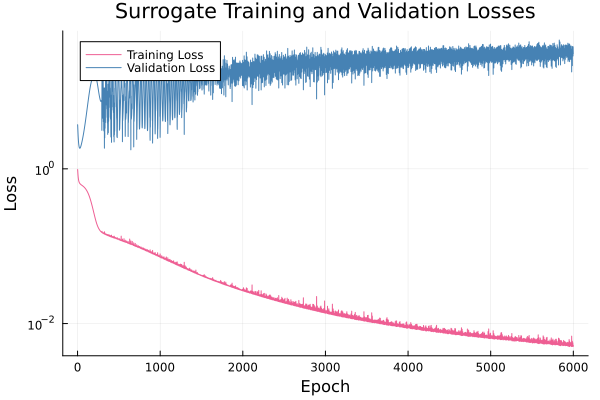

In [20]:
# Plot training and validation losses
p = plot(train_losses_sur, label = "Training Loss",xlabel = "Epoch",ylabel = "Loss",title = "Surrogate Training and Validation Losses", yscale = :log10, color=cur_colors[7])
plot!(val_losses_sur, label = "Validation Loss",yscale = :log10,color=:steelblue)
display(p)

### Surrogate Performance 

In [21]:
function rollout_surrogate(surrogate_model, h0, u0, times, tau_func, mu_X, sigma_X, mu_Y, sigma_Y, D_stations, mask, n_stations, amplitude_scale; init_condition=surrogate_init_state)
    """
    Perform a rollout using the surrogate model over the given time grid
    Inputs:
        surrogate_model  - trained surrogate (e.g. neural net)
        h0, u0           - initial states (arrays per station)
        times            - vector of time points
        tau_func         - function returning τ(t) forcing at time t
        mu_X, sigma_X    - normalization stats for inputs
        mu_Y, sigma_Y    - normalization stats for outputs
        D_stations       - station-specific features (e.g. distances)
        mask             - station mask (active/inactive flags)
        n_stations       - number of stations
        amplitude_scale  - global scaling factor

    Return: full rollout trajectories
    """

    # Initialize prediction arrays
    h_pred = zeros(length(times), length(h0))
    u_pred = zeros(length(times), length(u0))
    
    h_pred[1,:] = h0
    u_pred[1,:] = u0

    mu_Xf = Float32.(vec(mu_X))
    sigma_Xf = Float32.(vec(sigma_X))
    mu_Yf = Float32.(vec(mu_Y))
    sigma_Yf = Float32.(vec(sigma_Y))

    # Prepare IC encoding if using multi-IC surrogate
    ic_vec = nothing
    if use_multi_init
        ic_idx = ic_to_idx[init_condition]
        ic_vec = zeros(Float32, n_init_conditions)
        ic_vec[ic_idx] = 1.0f0
    end

    # Rollout loop over time steps
    for k in 1:(length(times) - 1)
        # Build raw input vector for this step
        input_vec = Float32[]
        tau_val = Float32(tau_func(times[k]))
        
        # Collect local features for each station
        for i in 1:n_stations
            append!(input_vec, [h_pred[k, i], u_pred[k, i], D_stations[i], mask[i], tau_val, amplitude_scale])
        end

        # Append IC encoding if needed
        if ic_vec !== nothing
            append!(input_vec, ic_vec)
        end
        
        # Normalize inputs
        input_norm = copy(input_vec)
        input_norm[norm_cols_X] = (input_vec[norm_cols_X] .- mu_Xf) ./ sigma_Xf
        input_norm[mask_cols_X] = input_vec[mask_cols_X]
        
        input_col = reshape(Float32.(input_norm), :, 1)

        # Surrogate prediction
        pred_norm = surrogate_model(input_col)
        pred_vec = vec(Array(pred_norm))
        
        # Denormalize output
        pred_unnorm = copy(pred_vec)
        pred_unnorm[norm_cols_Y] = pred_vec[norm_cols_Y] .* sigma_Yf .+ mu_Yf

        # Update state
        if predict_increment
            h_pred[k + 1, :] = h_pred[k, :] .+ pred_unnorm[1:n_stations]
            u_pred[k + 1, :] = u_pred[k, :] .+ pred_unnorm[(n_stations+1):end]
        else
            h_pred[k + 1, :] = pred_unnorm[1:n_stations]
            u_pred[k + 1, :] = pred_unnorm[(n_stations+1):end]
        end
    end

    return h_pred, u_pred
end

H_surrogate, U_surrogate = rollout_surrogate(surrogate_model, H_nominal[1, :], U_nominal[1, :], times, tau_nominal, mu_X, sigma_X, mu_Y, sigma_Y, D_stations, mask, n_stations, 1.0f0)

nothing

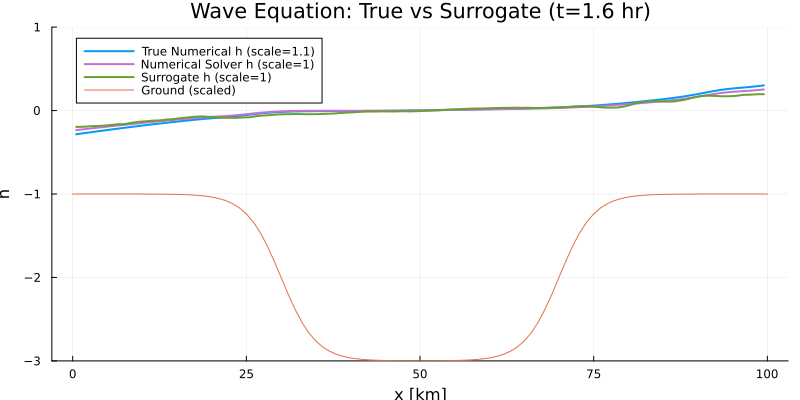

In [22]:
# Snapshot comparison at time i
i = 100
p = plot(1e-3 * x_h, sol_true[i].h, label="True Numerical h (scale=$bias_factor)", xlabel="x [km]", ylabel="h", ylim=(-3, 1), lw=2)
plot!(1e-3 * x_h, sol_nominal_full[i].h, label="Numerical Solver h (scale=1)", linestyle=:solid, lw=2, color=cur_colors[4])
plot!(1e-3 * x_h, H_surrogate[i, :], label="Surrogate h (scale=1)", linestyle=:solid, lw=2, color=cur_colors[end])
plot!(1e-3 * x_u, -0.1 * D, label="Ground (scaled)", lw=1, color=cur_colors[2])
plot!(p, size=(800,400), title="Wave Equation: True vs Surrogate (t=$(round(sol_true.t[i]/3600, digits=1)) hr)")
display(p)

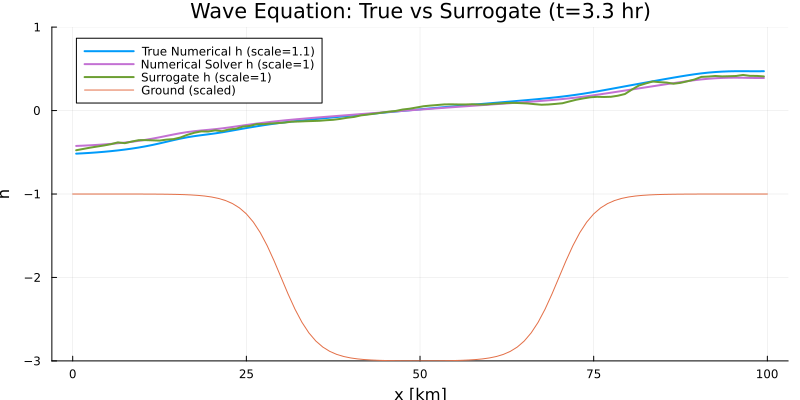

In [23]:
# Snapshot comparison at time i
i = 200
p = plot(1e-3 * x_h, sol_true[i].h, label="True Numerical h (scale=$bias_factor)", xlabel="x [km]", ylabel="h", ylim=(-3, 1), lw=2)
plot!(1e-3 * x_h, sol_nominal_full[i].h, label="Numerical Solver h (scale=1)", linestyle=:solid, lw=2, color=cur_colors[4])
plot!(1e-3 * x_h, H_surrogate[i, :], label="Surrogate h (scale=1)", linestyle=:solid, lw=2, color=cur_colors[end])
plot!(1e-3 * x_u, -0.1 * D, label="Ground (scaled)", lw=1, color=cur_colors[2])
plot!(p, size=(800,400), title="Wave Equation: True vs Surrogate (t=$(round(sol_true.t[i]/3600, digits=1)) hr)")
display(p)

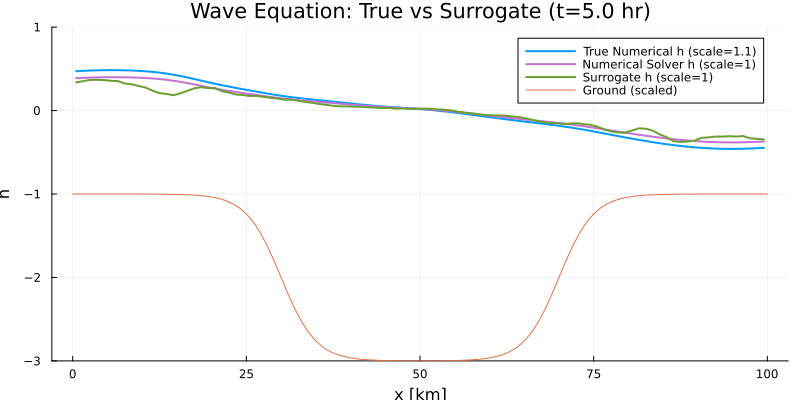

In [24]:
# Snapshot comparison at time i
i = 300
p = plot(1e-3 * x_h, sol_true[i].h, label="True Numerical h (scale=$bias_factor)", xlabel="x [km]", ylabel="h", ylim=(-3, 1), lw=2)
plot!(1e-3 * x_h, sol_nominal_full[i].h, label="Numerical Solver h (scale=1)", linestyle=:solid, lw=2, color=cur_colors[4])
plot!(1e-3 * x_h, H_surrogate[i, :], label="Surrogate h (scale=1)", linestyle=:solid, lw=2, color=cur_colors[end])
plot!(1e-3 * x_u, -0.1 * D, label="Ground (scaled)", lw=1, color=cur_colors[2])
plot!(p, size=(800,400), title="Wave Equation: True vs Surrogate (t=$(round(sol_true.t[i]/3600, digits=1)) hr)")
display(p)

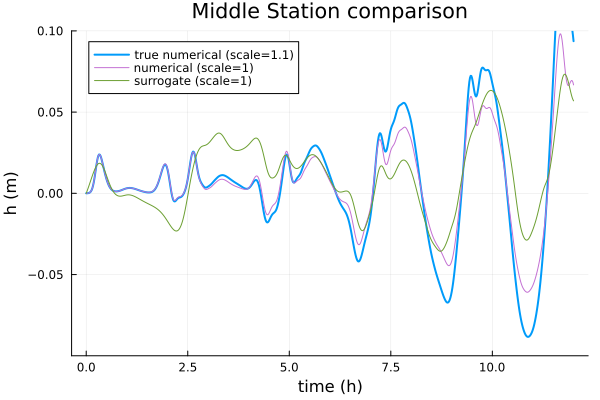

In [25]:
# Rollout comparison at a station s
s = station_idxs[end ÷ 2]
p = plot(times./3600, H_true[:, s], label="true numerical (scale=$bias_factor)", lw=2, ylim=(-0.1, 0.1))
plot!(times./3600, H_nominal_full[:, s], label="numerical (scale=1)", color=cur_colors[4])
plot!(times./3600, H_surrogate[:, s], label="surrogate (scale=1)", color=cur_colors[end])
xlabel!("time (h)"); ylabel!("h (m)"); title!("Middle Station comparison")
display(p)

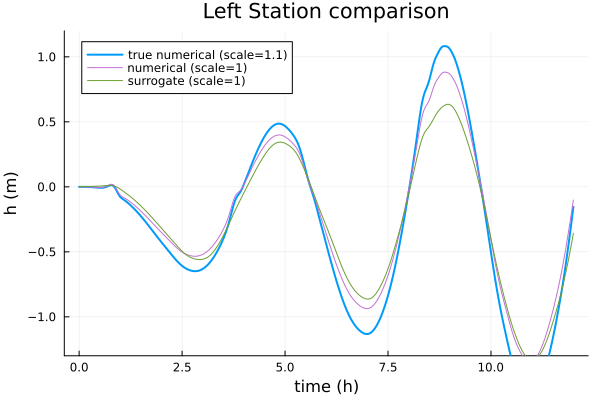

In [26]:
# Rollout comparison at a station s
s = station_idxs[1]
p = plot(times./3600, H_true[:, s], label="true numerical (scale=$bias_factor)", lw=2, ylim=(-1.3, 1.2))
plot!(times./3600, H_nominal_full[:, s], label="numerical (scale=1)", color=cur_colors[4])
plot!(times./3600, H_surrogate[:, s], label="surrogate (scale=1)", color=cur_colors[end])
xlabel!("time (h)"); ylabel!("h (m)"); title!("Left Station comparison")
display(p)

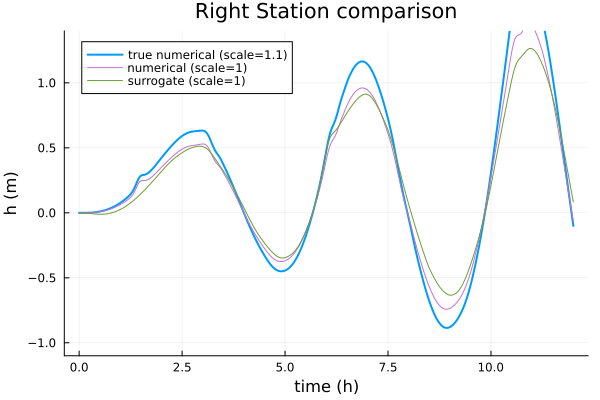

In [27]:
# Rollout comparison at a station s
s = station_idxs[end]
p = plot(times./3600, H_true[:, s], label="true numerical (scale=$bias_factor)", lw=2, ylim=(-1.1, 1.4))
plot!(times./3600, H_nominal_full[:, s], label="numerical (scale=1)", color=cur_colors[4])
plot!(times./3600, H_surrogate[:, s], label="surrogate (scale=1)", color=cur_colors[end])
xlabel!("time (h)"); ylabel!("h (m)"); title!("Right Station comparison")
display(p)

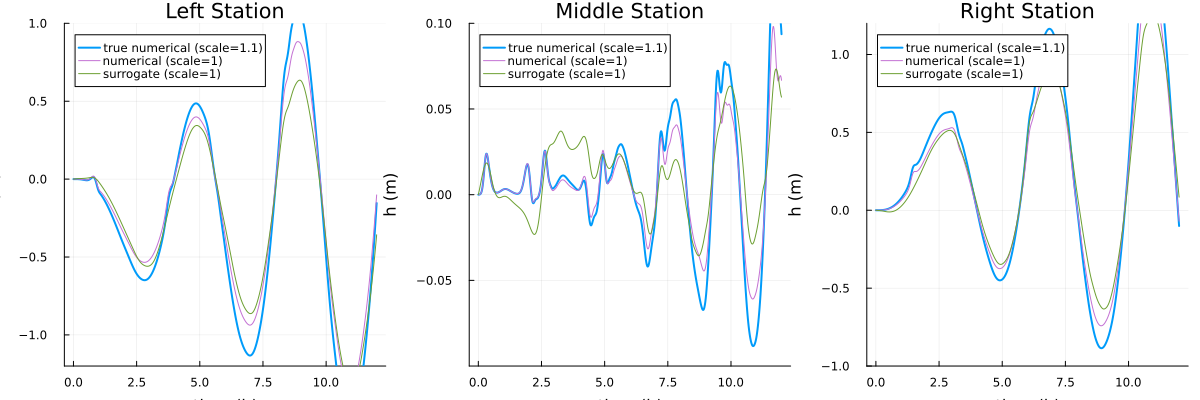

In [28]:
# Prepare the station indices
stations = [station_idxs[1], station_idxs[end ÷ 2], station_idxs[end]]
ylims = [(-1.2, 1), (-0.1, 0.1), (-1, 1.2)]
titles = ["Left Station", "Middle Station", "Right Station"]

plt = plot(layout = (1, 3), size=(1200, 400))

for (i, s) in enumerate(stations)
    plot!(plt[i], times ./ 3600, H_true[:, s], label="true numerical (scale=$bias_factor)", lw=2, ylim=ylims[i])
    plot!(plt[i], times ./ 3600, H_nominal_full[:, s], label="numerical (scale=1)", color=cur_colors[4])
    plot!(plt[i], times ./ 3600, H_surrogate[:, s], label="surrogate (scale=1)", color=cur_colors[end])
    xlabel!(plt[i], "time (h)")
    ylabel!(plt[i], "h (m)")
    title!(plt[i], titles[i])
end

display(plt)

In [29]:
# Save surrogate and training data
surrogate_data = Dict(
    :surrogate_seed => SEED,
    :mu_X => mu_X,
    :sigma_X => sigma_X, 
    :mu_Y => mu_Y,
    :sigma_Y => sigma_Y,

    :norm_cols_X => norm_cols_X,      
    :mask_cols_X => mask_cols_X,        
    :norm_cols_Y => norm_cols_Y,   
    :tau_col_idx => tau_col_idx,
    :scale_col_idx => 6,
    
    # Multi-Initial Condition 
    :INIT_STATES => INIT_STATES,  
    :n_init_conditions => n_init_conditions,  
    :ic_to_idx => ic_to_idx,  
    :idx_to_ic => idx_to_ic,  
    :ic_col_start => N_LOCAL_FEATURES * n_stations + 1, 
    
    # Multi-data configuration
    :N_LOCAL_FEATURES => N_LOCAL_FEATURES,   
    :TRAIN_SCALES => TRAIN_SCALES,
    :use_multi_data => use_multi_data,  
    :use_multi_init => use_multi_init,  
    :scales_combined => scales_combined,
    :init_states_combined => init_states_combined,  
    :predict_increment => predict_increment,  

    # Training data
    :X_train => X_train,
    :Y_train => Y_train,
    :X_train_n => X_train_n,
    :Y_train_n => Y_train_n,
    :X_val_n => X_val_n,
    :Y_val_n => Y_val_n,
    
    # Reference data (now combined from all ICs)
    :H_nominal => H_nominal,
    :U_nominal => U_nominal,  
    :D_stations => D_stations, 
    :mask => mask,   

    # Model configuration
    :n_train => n_train,
    :surrogate_init_state => surrogate_init_state, 
    :wind_name => wind_name,
    :longer => longer,
    :n_in => n_in,
    :n_out => n_out,
    :n_stations => n_stations,
    :station_idxs => station_idxs,

    # Physical parameters
    :params => Dict(
        :nx => nx,
        :t_start => t_start,
        :t_end => t_end,
        :dt_output => dt_output,
        :times => times,
        :L => L,
        :dx => dx,
        :grid_u => grid_u,
        :grid_h => grid_h,
        :rho => rho,
        :g => g,
        :W => W,
        :C => C,
        :D_min => D_min,
        :D_max => D_max,
        :D_edges => D_edges,
        :D_widths => D_widths,
        :D => D,
        :amplitude => amplitude,
        :bias_factor => bias_factor,
        :period => period,  
        :x0 => x0,
        :x_h => x_h,
        :x_u => x_u,
        :x => x,
        :total => total,
        :coeffs => coeffs,
        :sigma => sigma,
        :wind_seed => wind_seed,
        :avg_duration => avg_duration,
        :noise_level => noise_level,
        :periods => periods,
        :weights => weights,
        :n_stations => n_stations,
    )
)

nothing

In [30]:
mkpath("data")  

if longer
    @save "data/multidata_$(init_state)_$(wind_name)_surrogate_$(surrogate)-longer.jld2" surrogate_model H_surrogate surrogate_data
    println("saved surrogate model data at data/multidata_$(init_state)_$(wind_name)_surrogate_$(surrogate)-longer.jld2")
else
    @save "data/multidata_$(init_state)_$(wind_name)_surrogate_$(surrogate).jld2" surrogate_model H_surrogate surrogate_data
    println("saved surrogate model data at data/multidata_$(init_state)_$(wind_name)_surrogate_$(surrogate).jld2")
end
nothing

### Surrogate Performance with True Wind Forcing (1.1 $\cdot$ amplitude)

In [31]:
bias_test = 1.1
state_test = "flat"
nothing

In [32]:
println("\nRunning true simulation for $state_test with bias factor $bias_test...")

# Load model parameters for test case
if longer
    @load "data/$(state_test)_$(wind_name)_longer_parameters.jld2" params
else
    @load "data/$(state_test)_$(wind_name)_parameters.jld2" params
end

for (k, v) in params
    eval(:($(Symbol(k)) = $v))
end

# test wind forcing 
if wind_name == "piecewise"
    tau_test = make_tau_piecewise(amplitude=(amplitude * bias_test), avg_duration=avg_duration, noise_level=noise_level, seed=wind_seed)
elseif wind_name == "periodic"
    tau_test = make_tau_periodic((amplitude * bias_test), period)
elseif wind_name == "multi-frequency" 
    tau_test = make_tau_multifreq(amplitude=(amplitude * bias_test), periods=periods, weights=weights, seed=wind_seed)
end

# Run true model with the test parameters
f_test = Wave1DSurge_cpu(g, D, L, W, dx, nx, rho, C, tau_test, q_left, q_right)
@time sol_test, H_true_test, U_true_test = run_model_and_extract(f_test, x0, times, station_idxs)
@time Y_test, U_test = rollout_surrogate(surrogate_model, H_true_test[1, :], U_true_test[1, :], times, tau_test, mu_X, sigma_X, mu_Y, sigma_Y, D_stations, mask, n_stations, bias_test)

nothing


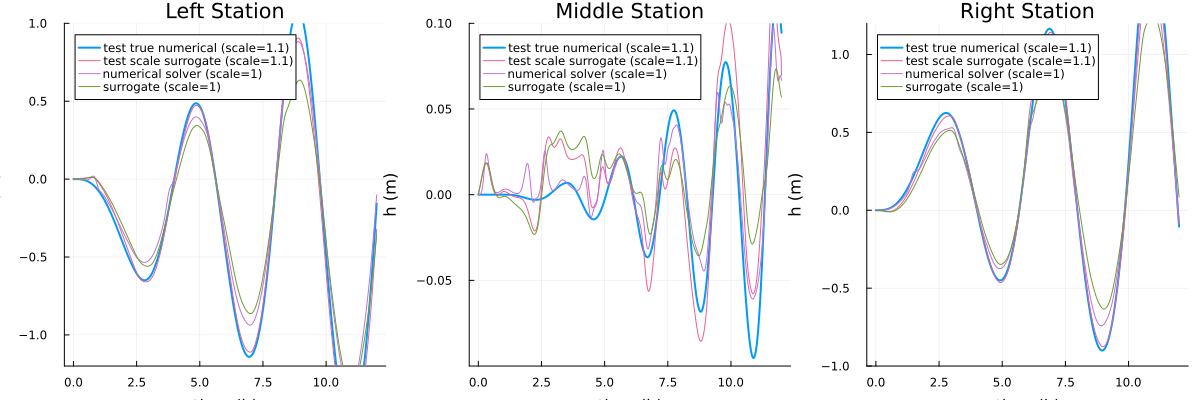

In [33]:
# Prepare the station indices
stations = [station_idxs[1], station_idxs[end ÷ 2], station_idxs[end]]
ylims = [(-1.2, 1.0), (-0.1, 0.1), (-1.0, 1.2)]
titles = ["Left Station", "Middle Station", "Right Station"]

plt = plot(layout = (1, 3), size=(1200, 400))

for (i, s) in enumerate(stations)
    plot!(plt[i], times ./ 3600, H_true_test[:, s], label="test true numerical (scale=$bias_test)", lw=2, ylim=ylims[i])
    plot!(plt[i], times ./ 3600, Y_test[:, s], label="test scale surrogate (scale=$bias_test)", color=cur_colors[7])
    plot!(plt[i], times ./ 3600, H_nominal_full[:, s], label="numerical solver (scale=1)", color=cur_colors[4])
    plot!(plt[i], times ./ 3600, H_surrogate[:, s], label="surrogate (scale=1)", color=cur_colors[end])
    xlabel!(plt[i], "time (h)")
    ylabel!(plt[i], "h (m)")
    title!(plt[i], titles[i])
end

display(plt)

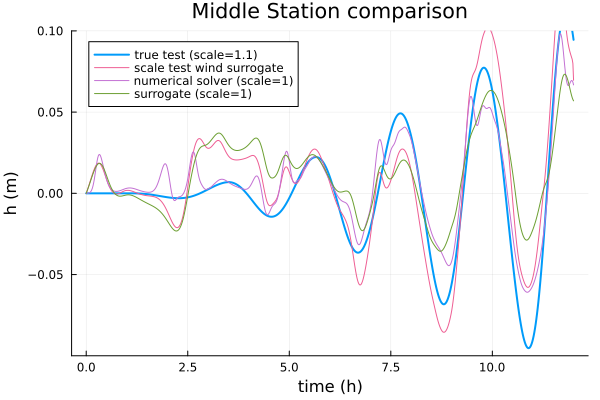

In [34]:
# Rollout comparison at a station s
s = station_idxs[end ÷ 2]
p = plot(times./3600, H_true_test[:, s], label="true test (scale=$bias_test)", lw=2, ylim=(-0.1, 0.1))
plot!(times./3600, Y_test[:, s], label="scale test wind surrogate", color=cur_colors[7])
plot!(times./3600, H_nominal_full[:, s], label="numerical solver (scale=1)", color=cur_colors[4])
plot!(times./3600, H_surrogate[:, s], label="surrogate (scale=1)", color=cur_colors[end])
xlabel!("time (h)"); ylabel!("h (m)"); title!("Middle Station comparison")
display(p)

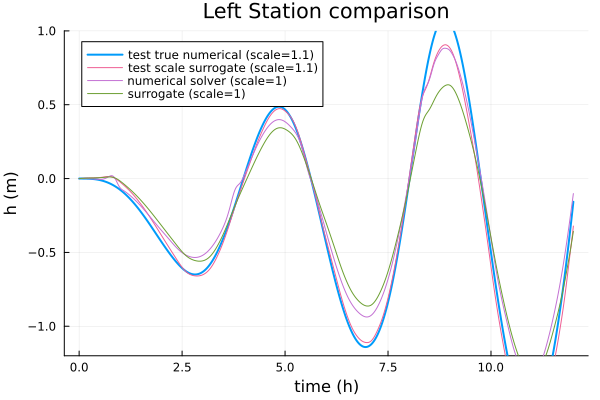

In [35]:
# Rollout comparison at a station s
s = station_idxs[1]
p = plot(times./3600, H_true_test[:, s], label="test true numerical (scale=$bias_test)", lw=2, ylim=(-1.2, 1))
plot!(times./3600, Y_test[:, s], label="test scale surrogate (scale=$bias_test)", color=cur_colors[7])
plot!(times./3600, H_nominal_full[:, s], label="numerical solver (scale=1)", color=cur_colors[4])
plot!(times./3600, H_surrogate[:, s], label="surrogate (scale=1)", color=cur_colors[end])
xlabel!("time (h)"); ylabel!("h (m)"); title!("Left Station comparison")
display(p)

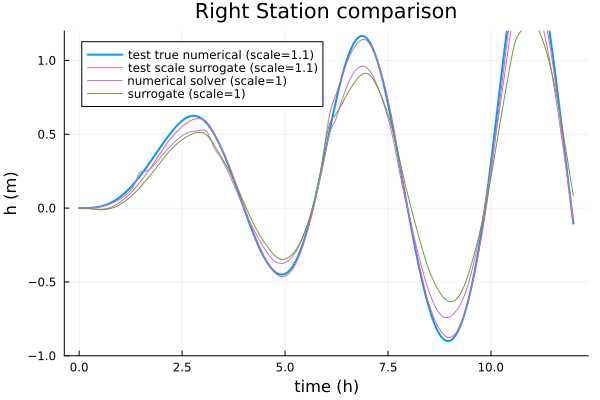

In [36]:
# Rollout comparison at a station s
s = station_idxs[end]
p = plot(times./3600, H_true_test[:, s], label="test true numerical (scale=$bias_test)", lw=2, ylim=(-1, 1.2))
plot!(times./3600, Y_test[:, s], label="test scale surrogate (scale=$bias_test)", color=cur_colors[7])
plot!(times./3600, H_nominal_full[:, s], label="numerical solver (scale=1)", color=cur_colors[4])
plot!(times./3600, H_surrogate[:, s], label="surrogate (scale=1)", color=cur_colors[end])
xlabel!("time (h)"); ylabel!("h (m)"); title!("Right Station comparison")
display(p)

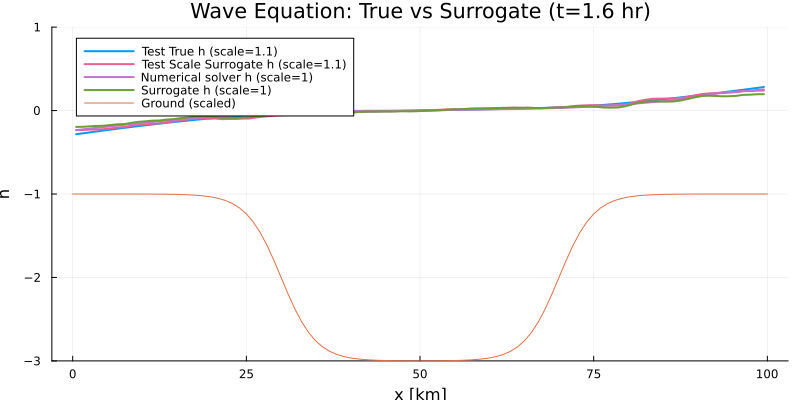

In [37]:
# Snapshot comparison at time i
i = 100
p = plot(1e-3 * x_h, sol_test[i].h, label="Test True h (scale=$bias_test)", xlabel="x [km]", ylabel="h", ylim=(-3, 1), lw=2)
plot!(1e-3 * x_h, Y_test[i, :], label="Test Scale Surrogate h (scale=$bias_test)", linestyle=:solid, lw=2, color=cur_colors[7])
plot!(1e-3 * x_h, sol_nominal_full[i].h, label="Numerical solver h (scale=1)", linestyle=:solid, lw=2, color=cur_colors[4])
plot!(1e-3 * x_h, H_surrogate[i, :], label="Surrogate h (scale=1)", linestyle=:solid, lw=2, color=cur_colors[end])
plot!(1e-3 * x_u, -0.1 * D, label="Ground (scaled)", lw=1, color=cur_colors[2])
plot!(p, size=(800,400), title="Wave Equation: True vs Surrogate (t=$(round(sol_true.t[i]/3600, digits=1)) hr)")
display(p)

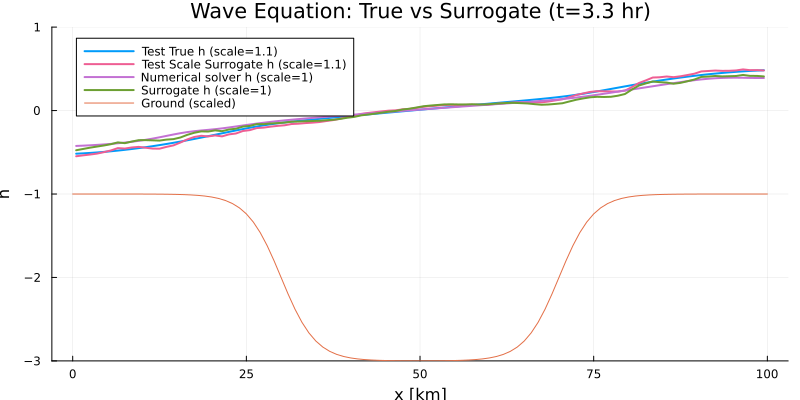

In [38]:
# Snapshot comparison at time i
i = 200
p = plot(1e-3 * x_h, sol_test[i].h, label="Test True h (scale=$bias_test)", xlabel="x [km]", ylabel="h", ylim=(-3, 1), lw=2)
plot!(1e-3 * x_h, Y_test[i, :], label="Test Scale Surrogate h (scale=$bias_test)", linestyle=:solid, lw=2, color=cur_colors[7])
plot!(1e-3 * x_h, sol_nominal_full[i].h, label="Numerical solver h (scale=1)", linestyle=:solid, lw=2, color=cur_colors[4])
plot!(1e-3 * x_h, H_surrogate[i, :], label="Surrogate h (scale=1)", linestyle=:solid, lw=2, color=cur_colors[end])
plot!(1e-3 * x_u, -0.1 * D, label="Ground (scaled)", lw=1, color=cur_colors[2])
plot!(p, size=(800,400), title="Wave Equation: True vs Surrogate (t=$(round(sol_true.t[i]/3600, digits=1)) hr)")
display(p)

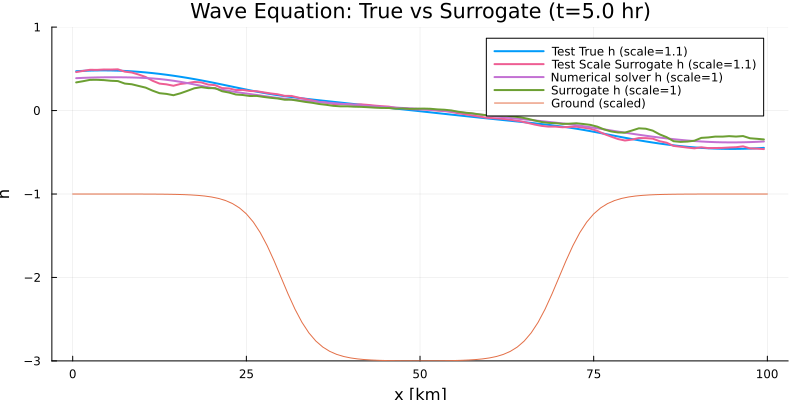

In [39]:
# Snapshot comparison at time i
i = 300
p = plot(1e-3 * x_h, sol_test[i].h, label="Test True h (scale=$bias_test)", xlabel="x [km]", ylabel="h", ylim=(-3, 1), lw=2)
plot!(1e-3 * x_h, Y_test[i, :], label="Test Scale Surrogate h (scale=$bias_test)", linestyle=:solid, lw=2, color=cur_colors[7])
plot!(1e-3 * x_h, sol_nominal_full[i].h, label="Numerical solver h (scale=1)", linestyle=:solid, lw=2, color=cur_colors[4])
plot!(1e-3 * x_h, H_surrogate[i, :], label="Surrogate h (scale=1)", linestyle=:solid, lw=2, color=cur_colors[end])
plot!(1e-3 * x_u, -0.1 * D, label="Ground (scaled)", lw=1, color=cur_colors[2])
plot!(p, size=(800,400), title="Wave Equation: True vs Surrogate (t=$(round(sol_true.t[i]/3600, digits=1)) hr)")
display(p)

Plots.AnimatedGif("/Users/sara/Desktop/Deltares/Final Report Code/Model-2/gif/surrogate_comparison_with_1.1flat_longertrue.gif")
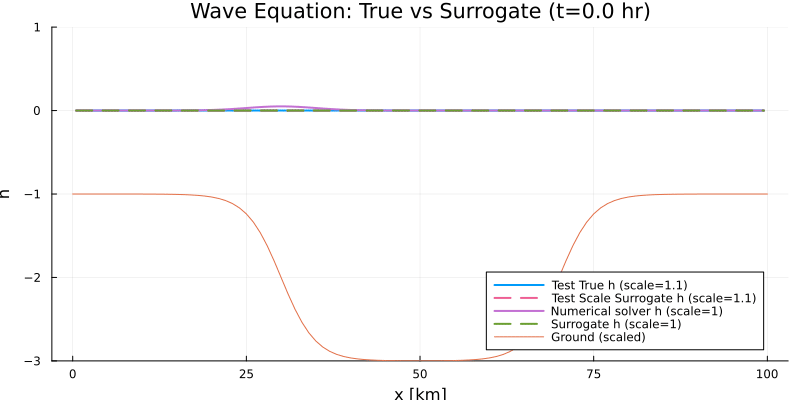

In [40]:
@time begin
    anim = @animate for i in 1:length(sol_true.t)
        p = plot(1e-3 * x_h, sol_test[i].h, label="Test True h (scale=$bias_test)", xlabel="x [km]", ylabel="h", ylim=(-3, 1), lw=2)
        plot!(1e-3 * x_h, Y_test[i, :], label="Test Scale Surrogate h (scale=$bias_test)", linestyle=:dash, lw=2, color=cur_colors[7])
        plot!(1e-3 * x_h, sol_nominal_full[i].h, label="Numerical solver h (scale=1)", linestyle=:solid, lw=2, color=cur_colors[4])
        plot!(1e-3 * x_h, H_surrogate[i, :], label="Surrogate h (scale=1)", linestyle=:dash, lw=2, color=cur_colors[end])
        plot!(1e-3 * x_u, -0.1 * D, label="Ground (scaled)", lw=1, color=cur_colors[2])
        plot!(p, size=(800,400), title="Wave Equation: True vs Surrogate (t=$(round(sol_true.t[i]/3600, digits=1)) hr)")
    end
    gif(anim, "gif/surrogate_comparison_with_$(bias_test)$(state_test)_longer$longer.gif", fps=30)
end